In [1]:
import numpy as np
import scipy

import cupy as cp
import cupyx.scipy

import astropy.units as u
from astropy.io import fits
from matplotlib.patches import Rectangle, Circle
from pathlib import Path
from IPython.display import clear_output, display, HTML
display(HTML("<style>.container { width:90% !important; }</style>")) # just making the notebook cells wider
from datetime import datetime

today = int(datetime.today().strftime('%Y%m%d'))

from importlib import reload
import time

import logging, sys
poppy_log = logging.getLogger('poppy')
poppy_log.setLevel('DEBUG')
logging.basicConfig(stream=sys.stdout, level=logging.INFO)

poppy_log.disabled = True

import warnings
warnings.filterwarnings("ignore")

import cgi_phasec_poppy

import ray
if not ray.is_initialized():
    ray.init(log_to_driver=False)
    
from math_module import xp, ensure_np_array
import iefc_2dm 
import utils
from imshows import *

data_dir = iefc_2dm.iefc_data_dir
response_dir = data_dir/'response-data'


INFO:numexpr.utils:Note: NumExpr detected 64 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.
INFO:numexpr.utils:NumExpr defaulting to 8 threads.


2023-10-17 10:01:17,417	INFO worker.py:1636 -- Started a local Ray instance.


![Alt text](image.png)

1.3624486320346218e-17 sr
	Flux for wavelength 8.130e-07 m: 3.998e+08 ph / (s m2)
	Flux for wavelength 8.250e-07 m: 3.840e+08 ph / (s m2)
	Flux for wavelength 8.370e-07 m: 3.691e+08 ph / (s m2)
Total flux: 1.153e+09 ph / (s m2)


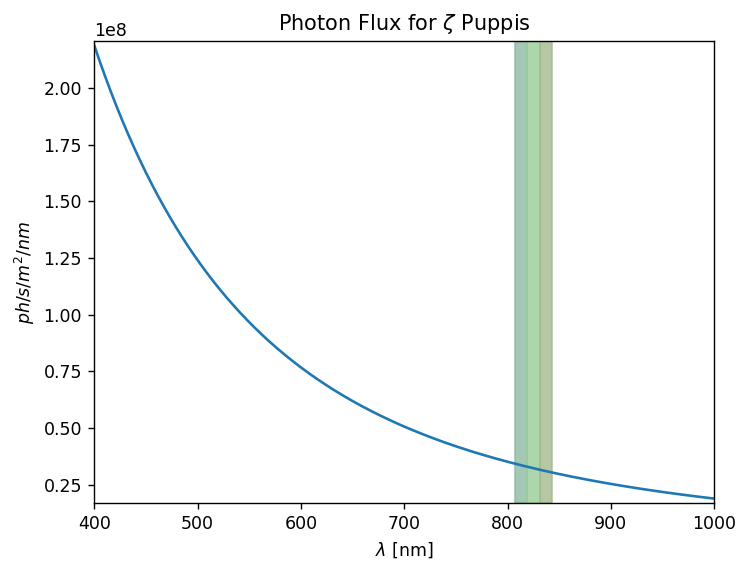

In [2]:
reload(cgi_phasec_poppy.source_flux)

wavelength_c = 825e-9*u.m

nwaves = 3
bandwidth = 2.9/100
minwave = wavelength_c * (1 - bandwidth/2)
maxwave = wavelength_c * (1 + bandwidth/2)
wavelengths = np.linspace( minwave, maxwave, nwaves )

minlam = 400*u.nm
maxlam = 1000*u.nm
nlam = int((maxlam-minlam).value*20) + 1
lambdas = np.linspace(minlam, maxlam, nlam)

from astropy.constants import h, c, k_B, R_sun

zpup = cgi_phasec_poppy.source_flux.SOURCE(wavelengths=wavelengths,
                                            temp=40000*u.K,
                                            distance=300*u.parsec,
                                            diameter=2*14*R_sun,
                                            name='$\zeta$ Puppis', 
                                            lambdas=lambdas,
                                           )

zpup.plot_spectrum_ph()
source_fluxes = zpup.calc_fluxes()
total_flux = np.sum(source_fluxes)

for i,flux in enumerate(source_fluxes):
    print(f'\tFlux for wavelength {wavelengths[i]:.3e}: {flux:.3e}')
print(f'Total flux: {total_flux:.3e}')

In [3]:
reload(cgi_phasec_poppy.cgi)
reload(cgi_phasec_poppy.parallelized_cgi)

rayCGI = ray.remote(cgi_phasec_poppy.cgi.CGI) # make a ray actor class from the original CGI class  

kwargs = {
    'cgi_mode':'spc-wide',
    'npsf':150,
    'use_pupil_defocus':True,
    'use_opds':True,
    'polaxis':0,
}

actors = []
for i in range(nwaves):
    actors.append(rayCGI.options(num_cpus=2, num_gpus=1/8).remote(**kwargs))
    actors[i].setattr.remote('wavelength', wavelengths[i])
    actors[i].setattr.remote('source_flux', source_fluxes[i])

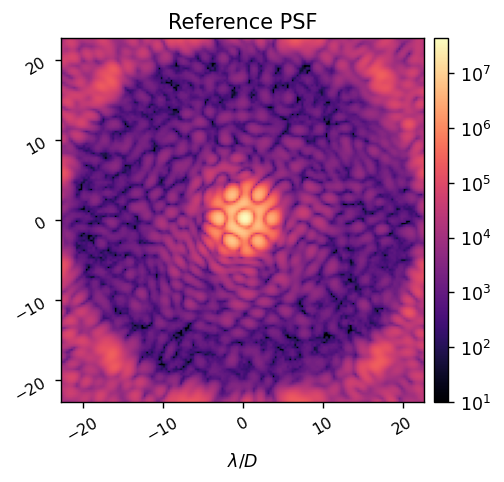

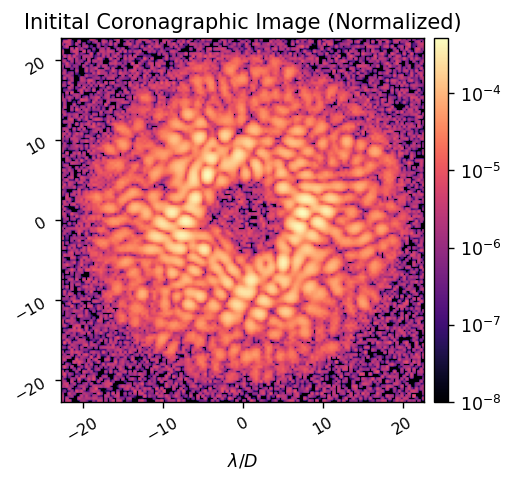

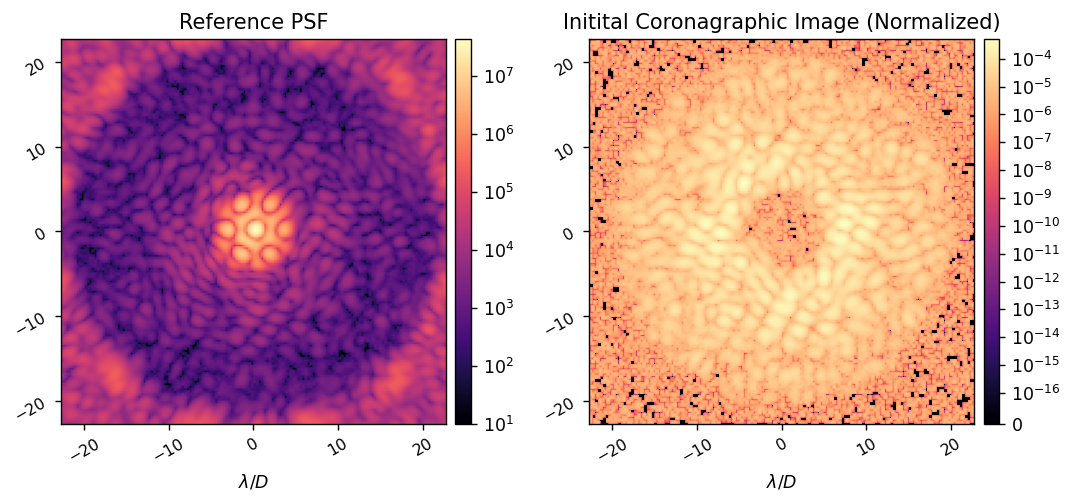

In [4]:
reload(cgi_phasec_poppy.parallelized_cgi)
mode = cgi_phasec_poppy.parallelized_cgi.ParallelizedCGI(actors=actors)

mode.use_noise = True
mode.exp_time = 2*u.s
mode.gain = 1
mode.dark_current_rate = 0.05*u.electron/u.pix/u.hour
mode.read_noise = 120*u.electron/u.pix

mode.set_actor_attr('use_fpm',False)
ref_unocc_im = mode.snap()
imshow1(ref_unocc_im, 'Reference PSF',
        pxscl=mode.psf_pixelscale_lamD, xlabel='$\lambda/D$', symlognorm=True, vmin=1e1)

mode.set_actor_attr('use_fpm',True)
max_ref = xp.max(ref_unocc_im)
mode.Imax_ref = max_ref
mode.exp_time_ref = mode.exp_time
mode.gain_ref = mode.gain

mode.exp_time = 2*u.s
mode.gain = 1

ref_im = mode.snap()
imshow1(ref_im, 'Initital Coronagraphic Image (Normalized)', 
        pxscl=mode.psf_pixelscale_lamD, xlabel='$\lambda/D$', symlognorm=True, vmin=1e-8)

imshow2(ref_unocc_im, ref_im, 'Reference PSF', 'Initital Coronagraphic Image (Normalized)', 
        pxscl=mode.psf_pixelscale_lamD, xlabel='$\lambda/D$', symlognorm1=True, vmin1=1e1, symlognorm2=True,
        # save_fig='test_bb_ims.png', 
        )

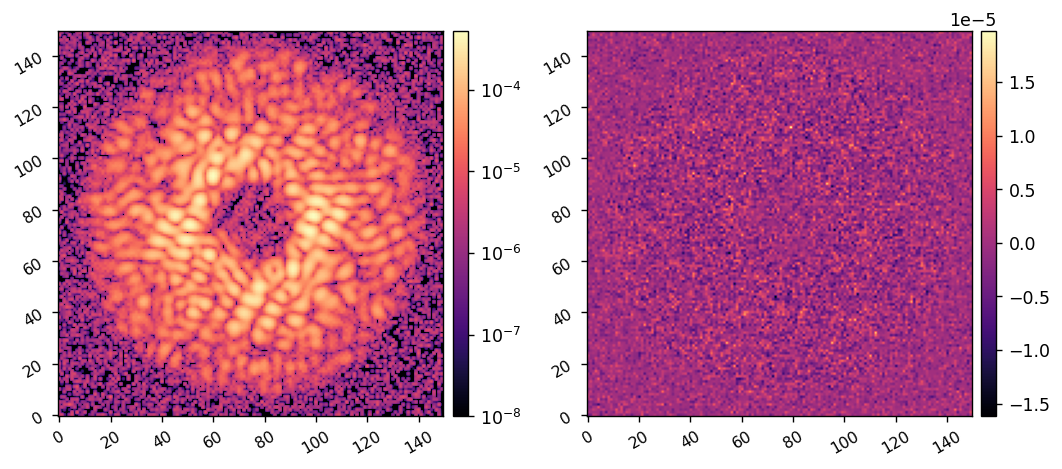

In [6]:
mode.exp_time = 2*u.s
mode.gain = 1
new_im = mode.snap()
imshow2(new_im, ref_im - new_im, symlognorm1=True, vmin1=1e-8)

# Create dark hole ROI to calibrate and control

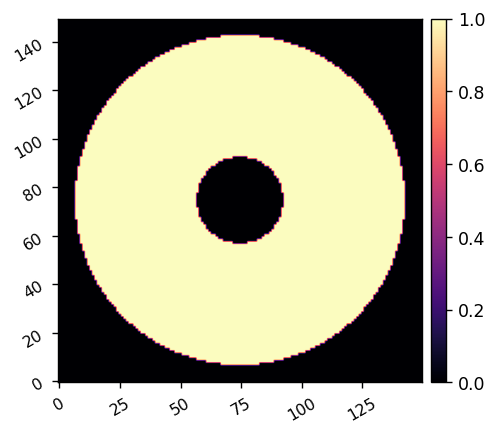

3.052444742319551e-05


In [5]:
reload(utils)
control_mask = utils.create_annular_focal_plane_mask(mode, inner_radius=5.4, outer_radius=20.6, edge=None, plot=True)

mean_ni = xp.mean(ref_im[control_mask])
print(mean_ni)

# Create calibration and probe modes

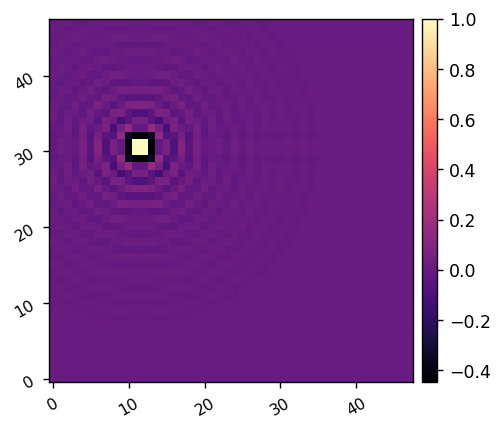

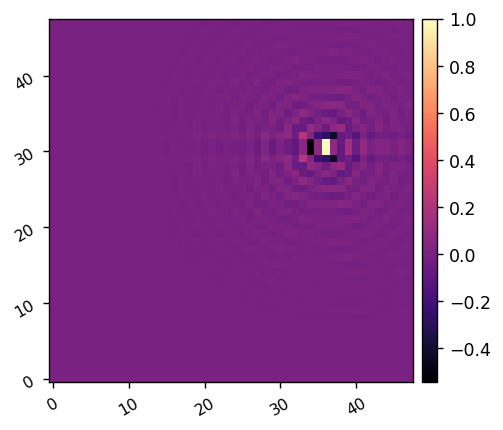

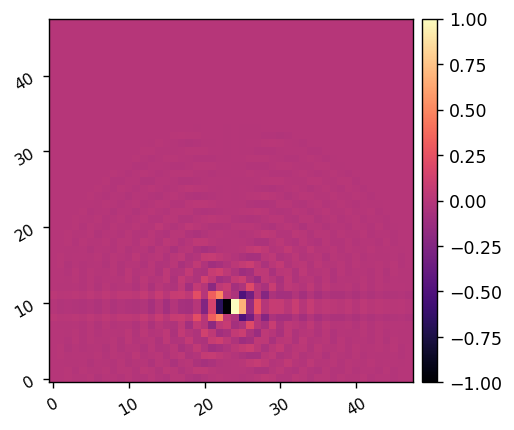

In [6]:
reload(utils)
probe_amp = 2.5e-8
probe_modes = utils.create_fourier_probes(mode, control_mask, fourier_sampling=0.2,
                                          shift=[(-12,7), (12,7),(0,-14), (0,0)], nprobes=3,
                                           use_weighting=True,
                                             plot=True)


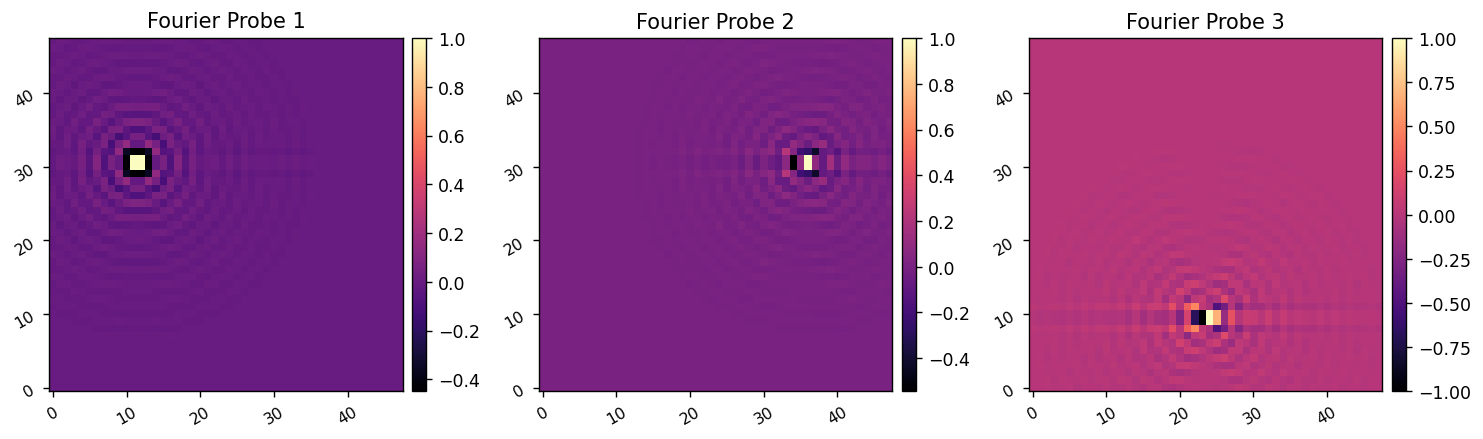

In [7]:
imshow3(probe_modes[0], probe_modes[1], probe_modes[2], 
        'Fourier Probe 1', 'Fourier Probe 2', 'Fourier Probe 3')

(4096, 4608)


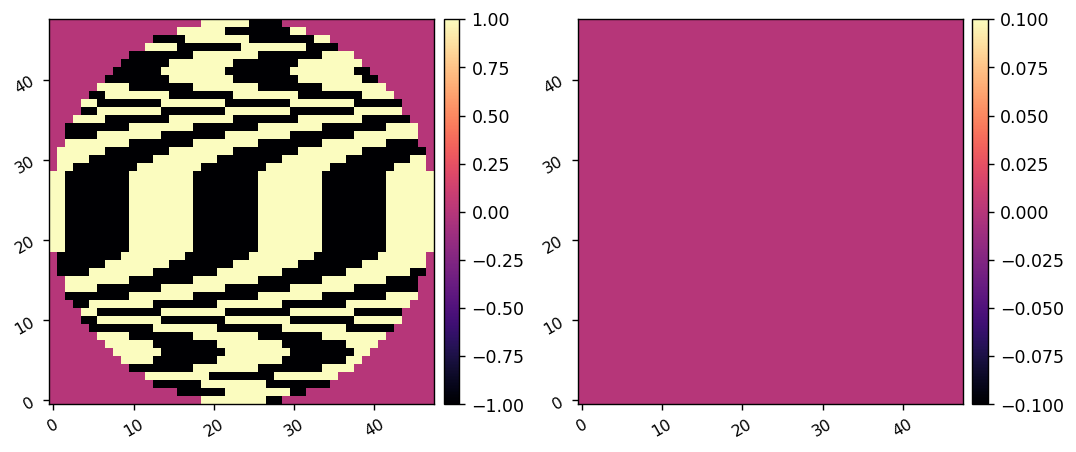

In [8]:
calib_amp = 10e-9
calib_modes = utils.create_hadamard_modes(mode.dm_mask, ndms=2)
Nmodes = calib_modes.shape[0]
print(calib_modes.shape)
i = 8
imshow2(calib_modes[i,:mode.Nact**2].reshape(mode.Nact,mode.Nact), calib_modes[i+mode.Nacts,mode.Nact**2:].reshape(mode.Nact,mode.Nact))


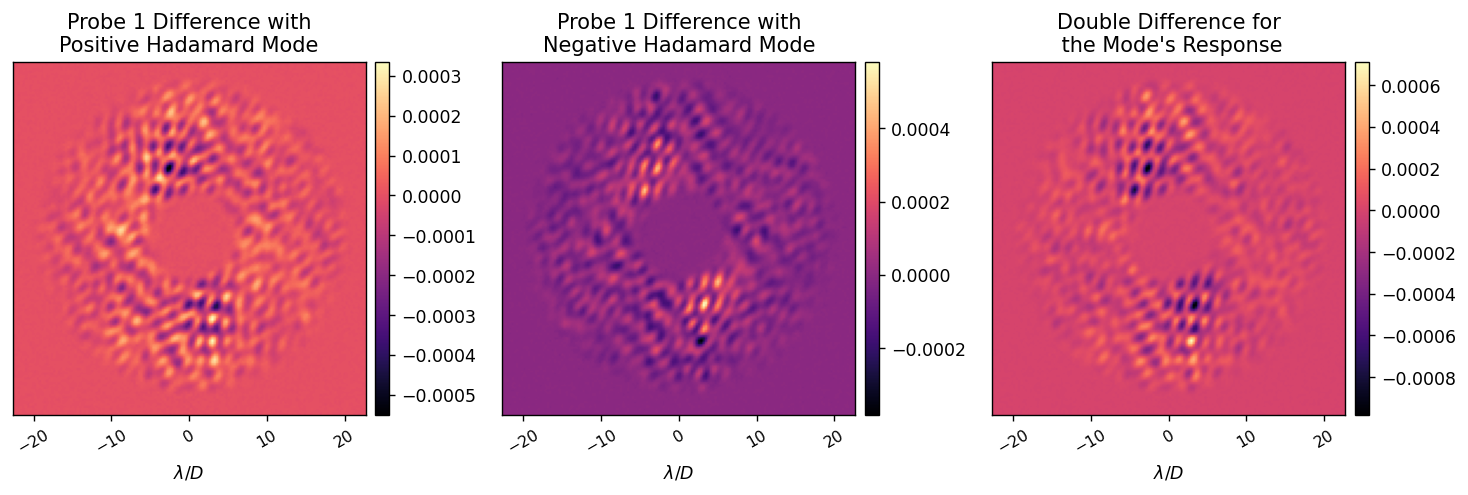

In [9]:
mode.exp_time = 2*u.s
mode.gain = 1

calib_amp = 10e-9

mode.add_dm1(calib_amp * calib_modes[i,:mode.Nact**2].reshape(mode.Nact,mode.Nact))
mode.add_dm1(probe_amp * probe_modes[0])
im1 = mode.snap()
mode.add_dm1(-2*probe_amp * probe_modes[0])
im2 = mode.snap()
mode.add_dm1(probe_amp * probe_modes[0])

mode.add_dm1(-2*calib_amp * calib_modes[i,:mode.Nact**2].reshape(mode.Nact,mode.Nact))
mode.add_dm1(probe_amp * probe_modes[0])
im3 = mode.snap()
mode.add_dm1(-2*probe_amp * probe_modes[0])
im4 = mode.snap()
mode.add_dm1(probe_amp * probe_modes[0])
mode.add_dm1(calib_amp * calib_modes[i,:mode.Nact**2].reshape(mode.Nact,mode.Nact))

del1 = im1-im2
del2 = im3-im4

deldel = del1 - del2

imshow3(del1, del2, deldel,
        'Probe 1 Difference with\nPositive Hadamard Mode',
        'Probe 1 Difference with\nNegative Hadamard Mode',
        'Double Difference for\n the Mode\'s Response',
        pxscl=mode.psf_pixelscale_lamD,
        yticks=[],
        xlabel='$\lambda/D$',
        )

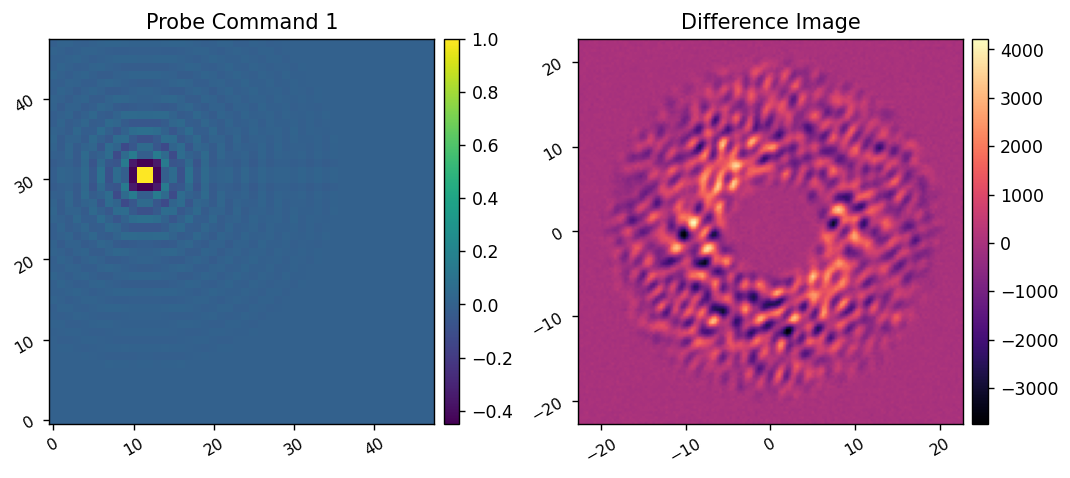

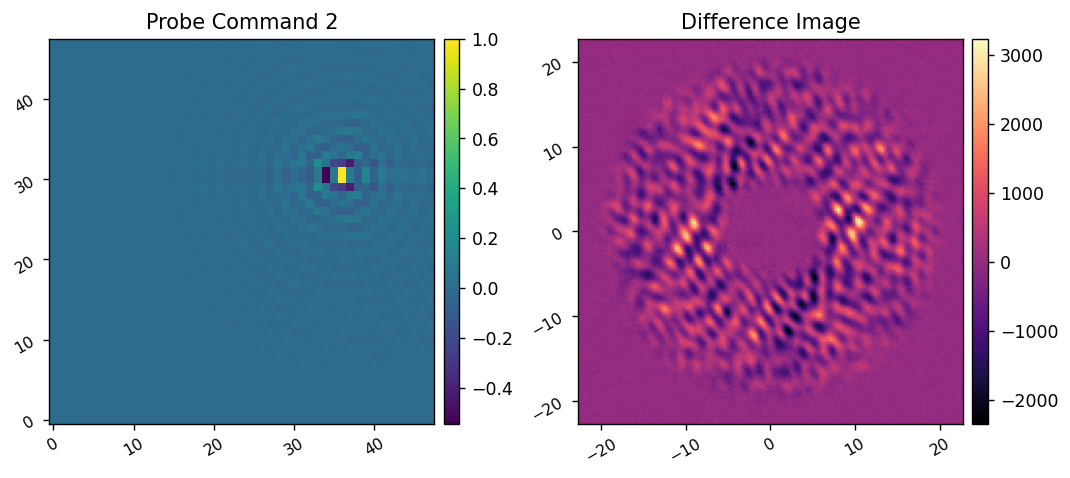

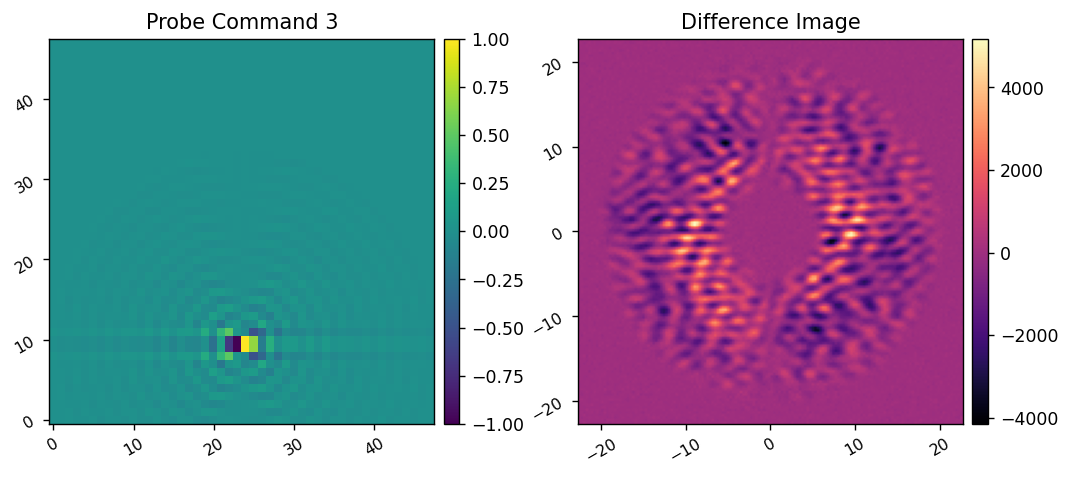

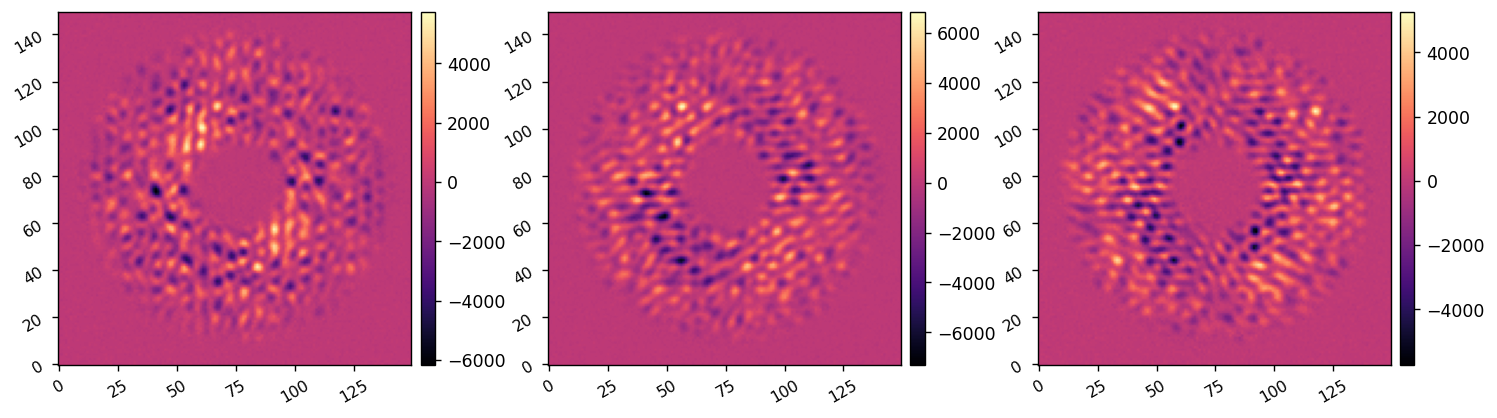

In [10]:
reload(iefc_2dm)

mode.reset_dms()

differential_images, single_images = iefc_2dm.take_measurement(mode, probe_modes, probe_amp, return_all=True, plot=True)
ims = differential_images.reshape(probe_modes.shape[0], mode.npsf, mode.npsf)
imshow3(ims[0]-ims[1], ims[0]-ims[2], ims[1]-ims[2])

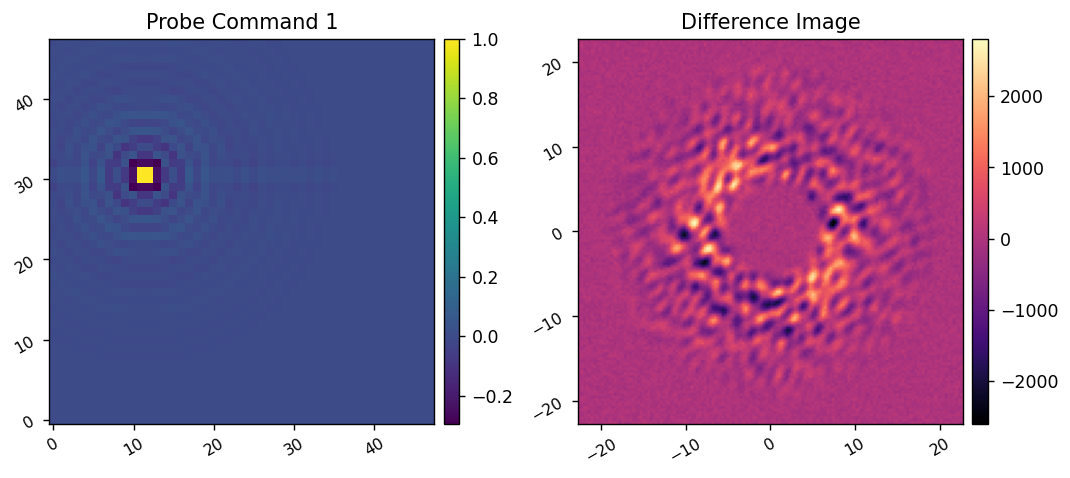

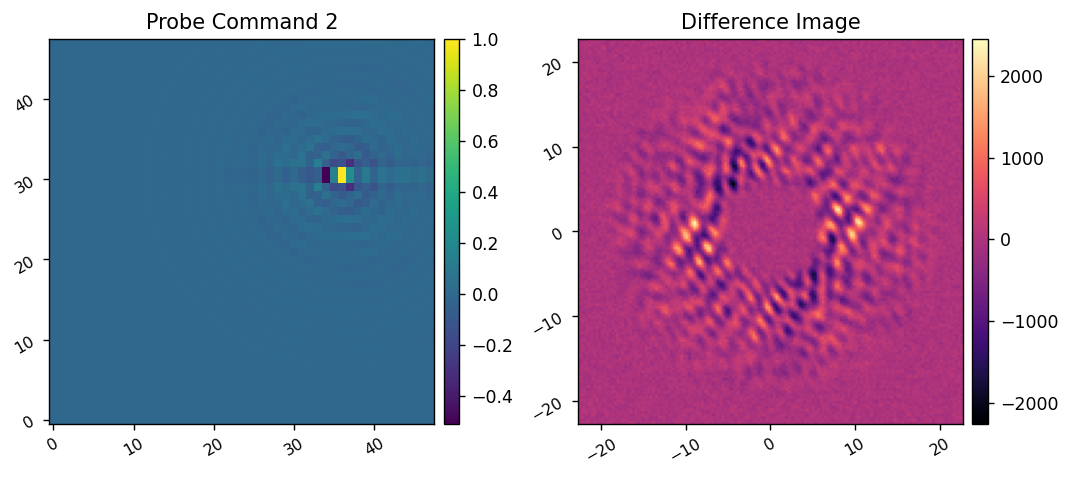

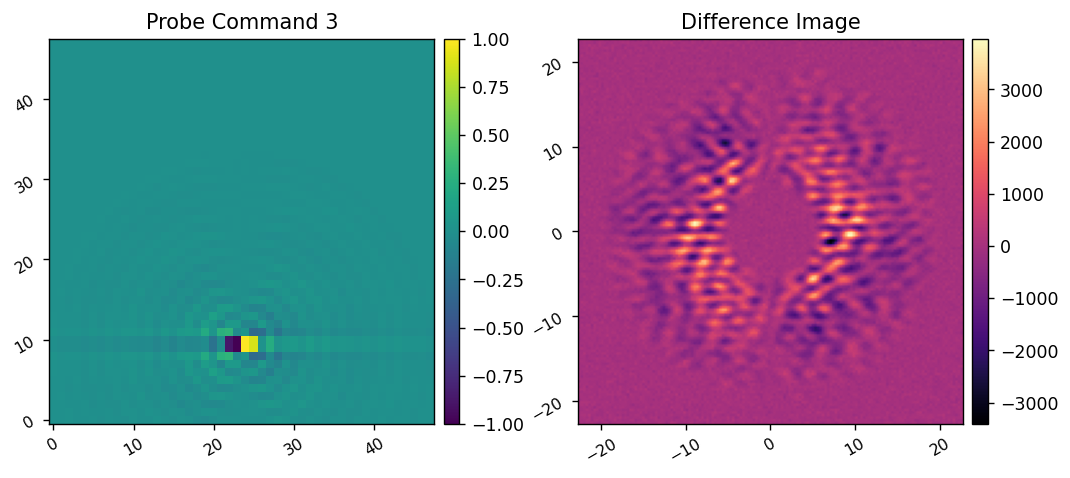

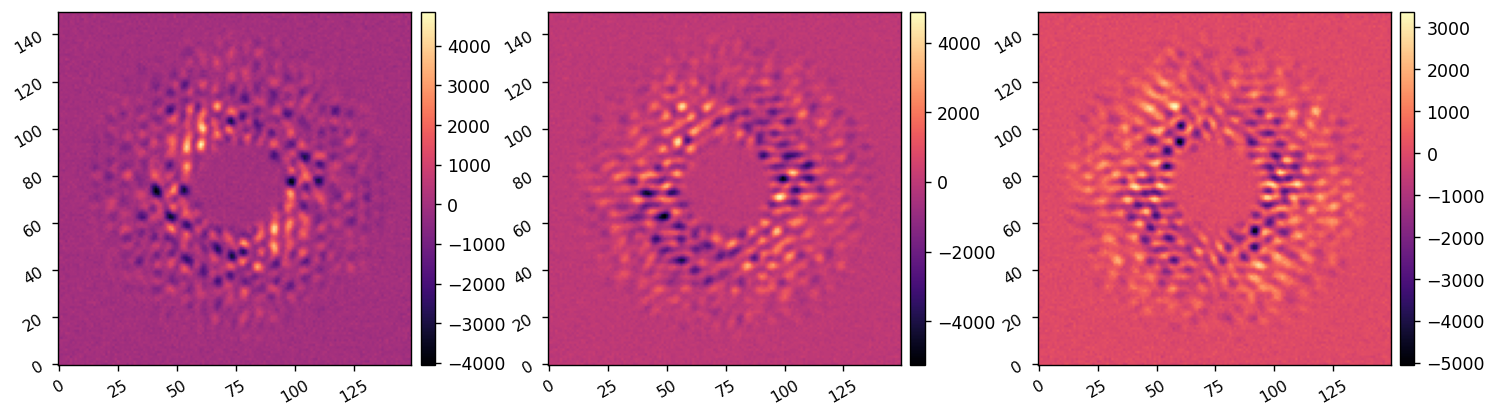

In [141]:
reload(iefc_2dm)

differential_images, single_images = iefc_2dm.take_measurement(mode, probe_modes, probe_amp, return_all=True, plot=True)
ims = differential_images.reshape(probe_modes.shape[0], mode.npsf, mode.npsf)
imshow3(ims[0]-ims[1], ims[0]-ims[2], ims[1]-ims[2])

Calibrating iEFC...
	Calibrated mode 10/10 in 116.097s
Calibration complete.


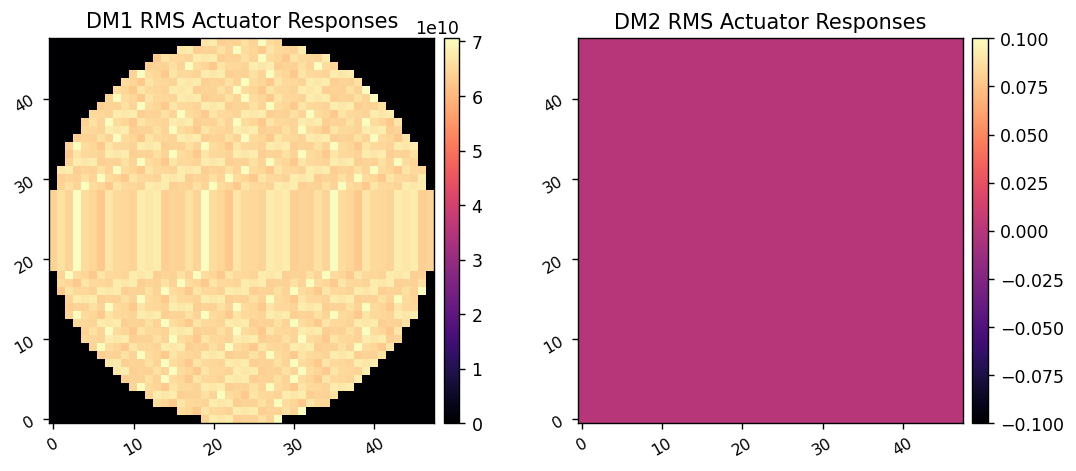

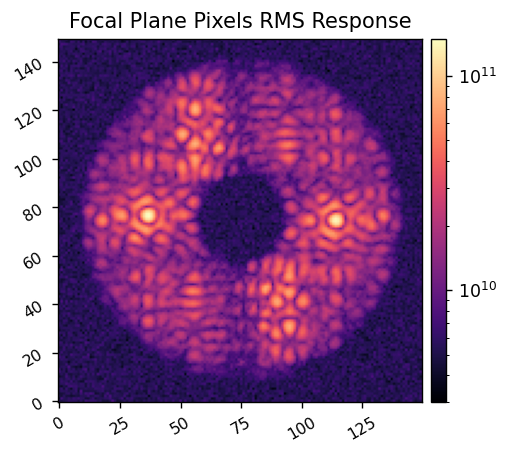

Saved data to:  /home/kianmilani/Projects/roman-cgi-iefc-data/response-data/test_response_matrix_20230928.fits
Saved data to:  /home/kianmilani/Projects/roman-cgi-iefc-data/response-data/test_response_cube_20230928.fits


In [154]:
reload(iefc_2dm)

calib_amp = 10e-9

response_matrix, response_cube = iefc_2dm.calibrate(mode, 
                                                    control_mask,
                                                    probe_amp, probe_modes, 
                                                     calib_amp, calib_modes[:10], 
                                                     return_all=True, 
#                                                     plot_responses=False,
                                                   )

utils.save_fits(response_dir/f'test_response_matrix_{today}.fits', response_matrix)
utils.save_fits(response_dir/f'test_response_cube_{today}.fits', response_cube)


In [11]:
date = 20230912
date = 20230913
date = 20230918
date = 20230920
date = 20230927
date = 20230928
response_matrix = xp.array(fits.getdata(response_dir/f'spc_wide_band4b_had_modes_response_matrix_{date}.fits'))
# response_cube = xp.array(fits.getdata(data_dir/response_dir/f'spc_wide_band4b_had_modes_response_cube_{date}.fits'))

# utils.save_fits(response_dir/f'spc_wide_band4b_had_modes_response_matrix_{date}.fits', response_matrix)
# utils.save_fits(response_dir/f'spc_wide_band4b_had_modes_response_cube_{date}.fits', response_cube)


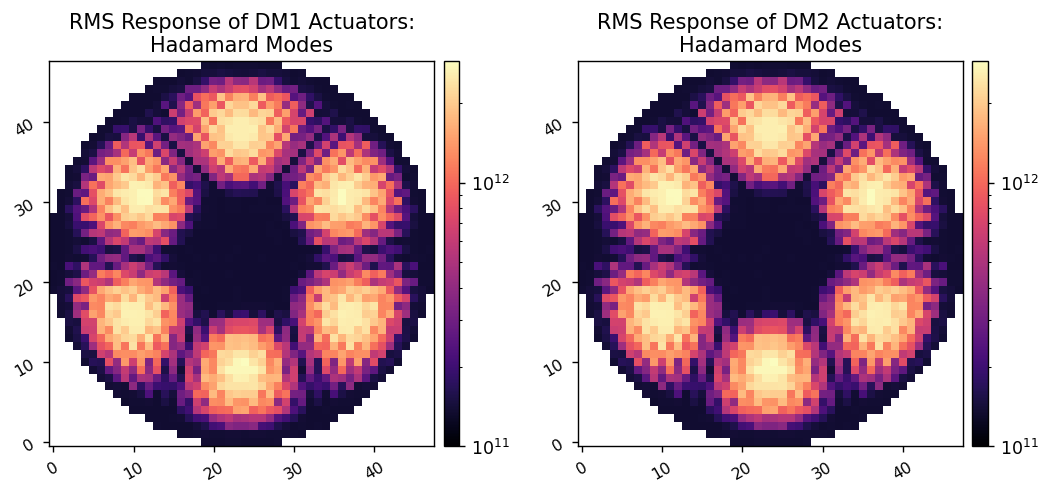

In [12]:
response_matrix.shape

dm_response = xp.sqrt(xp.mean(response_matrix.dot(xp.array(calib_modes))**2, axis=0))
dm1_response = dm_response[:mode.Nact**2].reshape(mode.Nact, mode.Nact)
dm2_response = dm_response[:mode.Nact**2].reshape(mode.Nact, mode.Nact)
imshow2(dm1_response, dm2_response, 
        'RMS Response of DM1 Actuators:\nHadamard Modes', 'RMS Response of DM2 Actuators:\nHadamard Modes',
        lognorm=True, vmin1=1e11, vmin2=1e11,
        )

# Run IEFC

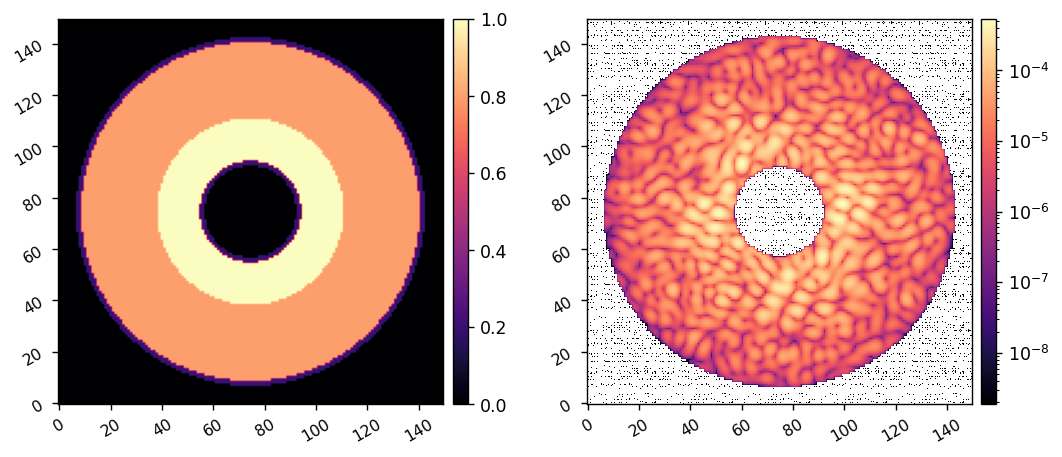

3.042688486608366e-05


In [ ]:
reload(utils)
roi1 = utils.create_annular_focal_plane_mask(mode, inner_radius=6, outer_radius=20, edge=None, )
roi2 = utils.create_annular_focal_plane_mask(mode, inner_radius=5.4, outer_radius=20.6, edge=None, )
roi3 = utils.create_annular_focal_plane_mask(mode, inner_radius=6, outer_radius=11, edge=None)

relative_weight_1 = 0.8
relative_weight_2 = 0.2
weight_map = roi3 + relative_weight_1*(roi1*~roi3) + relative_weight_2*(roi2*~roi1*~roi3)
control_mask = weight_map>0
imshow2(weight_map, control_mask*ref_im, lognorm2=True)
mean_ni = xp.mean(ref_im[control_mask])
print(mean_ni)

In [ ]:
mode.reset_dms()

images = xp.array([ref_im])
dm1_commands = xp.array([mode.get_dm1()])
dm2_commands = xp.array([mode.get_dm2()])

In [ ]:
reg_cond = 1e-2
control_matrix = utils.WeightedLeastSquares(response_matrix, rcond=reg_cond, weight_map=weight_map, nprobes=probe_modes.shape[0])


In [ ]:
probe_modes = probe_modes

In [ ]:
reload(iefc_2dm)
reload(utils)

images, dm1_commands, dm2_commands = iefc_2dm.run(mode, 
                                          control_matrix,
                                          probe_modes, 
                                          probe_amp, 
                                          calib_modes,
                                          control_mask, 
                                          num_iterations=5, 
                                          loop_gain=0.5, 
                                          leakage=0,
#                                                   use_fourier_filter=True,
                                          plot_all=True,
                                         plot_radial_contrast=False,
                                                  old_images=images,
                                                  old_dm1_commands=dm1_commands,
                                                  old_dm2_commands=dm2_commands,
                                         )

In [ ]:
utils.save_fits(response_dir/f'spc_wfov_band4b_had_fourier_dm1_commands_{date}.fits', dm1_commands)
utils.save_fits(response_dir/f'spc_wfov_band4b_had_fourier_dm2_commands_{date}.fits', dm2_commands)
utils.save_fits(response_dir/f'spc_wfov_band4b_had_fourier_images_{date}.fits', images)

Saved data to:  /home/kianmilani/Projects/roman-cgi-iefc-data/response-data/spc_wfov_825_had_dm1_commands_20231013.fits
Saved data to:  /home/kianmilani/Projects/roman-cgi-iefc-data/response-data/spc_wfov_825_had_dm2_commands_20231013.fits
Saved data to:  /home/kianmilani/Projects/roman-cgi-iefc-data/response-data/spc_wfov_825_had_images_20231013.fits
